In [43]:
using Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.10\Manifest.toml`


In [1]:
using Random
using Statistics

# Define the struct with required properties
mutable struct Lattice
    array::Vector{Int}                                # 1D array of 0's and 1's
    size::Int                                         # Size of the array
    density::Float64                                  # Fraction of 1's in the array
    temperature::Float64                              # Temperature parameter
    seed::Int                                         # Seed for random generation
    probability::Float64                              # Probability for swap
    step_count::Int                                   # Step count
    avg_pop::Vector{Float64}                          # Average population over time for each site
    second_moment_pop::Matrix{Float64}                # Second moments of population over time for each site
    equillibrium::Bool                                # A flag indicating if the lattice reached equillibrium
end

# Constructor to initialize the array based on size and density
function Lattice(size::Int, density::Float64, temperature::Float64,init::String="random", seed::Int=0)
    @assert size > 0 "Size must be a positive whole number"
    @assert 0.0 ≤ density ≤ 1.0 "Density must be between 0 and 1"
    @assert temperature ≥ 0.0 "Temperature must be non-negative"

    if seed != 0
        Random.seed!(seed)
    end
    # Calculate the number of 1's needed
    num_ones = round(Int, density * size)

    # Create an array with the exact number of 1's and 0's
    array = vcat(ones(Int, num_ones), zeros(Int, size - num_ones))

    # Shuffle the array to randomize the position of 1's and 0's
    if init == "random"
        array = shuffle(array)
    end
    avg_pop = zeros(Float64, size)
    second_moment_pop = zeros(Float64, size, size)
    equillibrium = false
    step_count = 1
    #check probs
    probability=exp(-1/temperature)

    return Lattice(array, size, density, temperature, seed, probability, step_count, avg_pop, second_moment_pop, equillibrium)
end

function calc_threshold(lattice::Lattice, index1::Int, index2::Int)
    # Ensure that index1 and index2 are valid and neighbors
    @assert abs(index1 - index2) == 1 || (index1 == 1 && index2 == lattice.size) || (index1 == lattice.size && index2 == 1) "Indices must be neighbors"
    if index1 == lattice.size
        neighbor1 = lattice.size - 1
        neighbor2 = 2
    else
        neighbor1 = mod(index1 - 2, lattice.size) + 1
        neighbor2 = mod(index2, lattice.size) + 1
    end

    if neighbor1 != neighbor2 && index1 == neighbor2
        return 1.0
    else
        return lattice.probability
    end
end


# Function to randomly choose a cell and swap it with a neighbor
function step(lattice::Lattice)
    index = rand(1:lattice.size)
    neighbor_index = mod(index, lattice.size) + 1

    if lattice.array[index] == lattice.array[neighbor_index]
        update_stats(lattice)
        return
    end
    threshold = calc_threshold(lattice, index, neighbor_index)
    
    if threshold == 1.0 || rand() < threshold
        lattice.array[index], lattice.array[neighbor_index] = 
        lattice.array[neighbor_index], lattice.array[index]
    end
    update_stats(lattice)
end

# Function to perform a sweep (step function `size` times)
function sweep(lattice::Lattice)
    for _ in 1:lattice.size
        step(lattice)
    end
end

function print_array_with_boxes(arr::Vector{Int})
    for value in arr
        if value == 1
            print("■")
        else
            print("□")
        end
    end
    println()  # Move to the next line after printing the array
end

function update_stats(lattice::Lattice)
    if lattice.equillibrium
        lattice.avg_pop .= lattice.avg_pop .+ float.(lattice.array)
        lattice.second_moment_pop .= lattice.second_moment_pop .+ (float.(lattice.array) * float.(lattice.array)')
        lattice.step_count = lattice.step_count + 1
    end
end

function flip_equillibrium_flag(lattice::Lattice)
    lattice.equillibrium = !lattice.equillibrium
    lattice.avg_pop = float.(lattice.array)
    lattice.second_moment_pop = float.(lattice.array) * float.(lattice.array)'
end

function get_avg_population(lattice::Lattice)
    return lattice.avg_pop / lattice.step_count
end

function get_correlation_array(lattice::Lattice)
    matrix = hcat(lattice.second_moment_pop, lattice.second_moment_pop) / (lattice.step_count)
    correlations = Float64[]
    for i in 0:floor(Int, lattice.size/2)
        avg_mult = lattice.avg_pop .* circshift(lattice.avg_pop, -i) / (lattice.step_count * lattice.step_count)
        corr = mean(extract_diagonal(matrix, i))# - avg_mult)
        push!(correlations, corr)
    end
    return correlations
end

function extract_diagonal(mat, k)
    n, m = size(mat)
    # Ensure that indices are within the valid range
    valid_indices = [i for i in 1:n if i + k >= 1 && i + k <= m]
    return [mat[i, i + k] for i in valid_indices]
end

function get_corr_len(correlations)
    indices = 0:length(correlations)-1  # Generate indices starting from 0
    weighted_sum = sum(indices .* correlations)  # Sum of index * value
    total_sum = sum(correlations)  # Sum of all values
    return weighted_sum / total_sum
end

get_corr_len (generic function with 1 method)

6651.144908 seconds (1.60 G allocations: 29.773 TiB, 14.10% gc time, 0.00% compilation time)
7160.550020 seconds (1.60 G allocations: 29.773 TiB, 12.97% gc time)
7123.134212 seconds (1.60 G allocations: 29.773 TiB, 12.90% gc time)
6987.999502 seconds (1.60 G allocations: 29.773 TiB, 12.64% gc time)
6968.128270 seconds (1.60 G allocations: 29.773 TiB, 12.61% gc time)
6894.213664 seconds (1.60 G allocations: 29.773 TiB, 12.55% gc time)
6941.249908 seconds (1.60 G allocations: 29.773 TiB, 12.70% gc time)
6995.733332 seconds (1.60 G allocations: 29.773 TiB, 12.84% gc time)
7037.339746 seconds (1.60 G allocations: 29.773 TiB, 12.72% gc time)
6947.027258 seconds (1.60 G allocations: 29.773 TiB, 11.77% gc time)


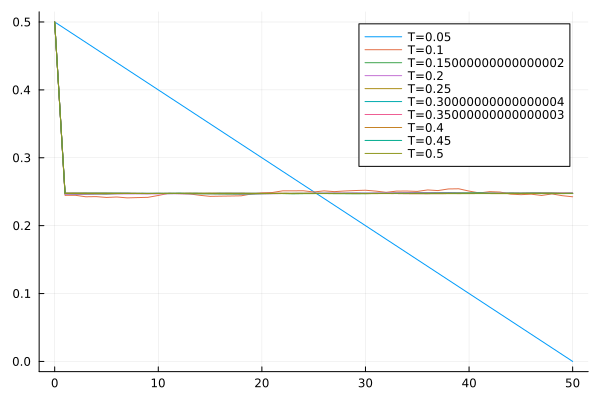

In [2]:
using Plots

results=[]
avgs=[]
repeat=10
lattice_size = 100
for i in 1:repeat
    @time begin
        temp = i * 0.05
        lattice = Lattice(lattice_size, 0.5, temp, "left")
        for _ in 1:(100000000 * 4)
            sweep(lattice)
        end
        
        flip_equillibrium_flag(lattice)
        for _ in 1:(1000000 * 4)
            sweep(lattice)
        end
        push!(results,get_correlation_array(lattice))
        push!(avgs, lattice.avg_pop .* circshift(lattice.avg_pop, -i) / (lattice.step_count * lattice.step_count))
    end
end

p = plot(0:floor(lattice_size/2), results[1], label="T=0.05")
for i in 2:repeat
    temp = i * 0.05
    plot!(p, 0:floor(lattice_size/2), results[i], label="T=$temp")
end
display(p)


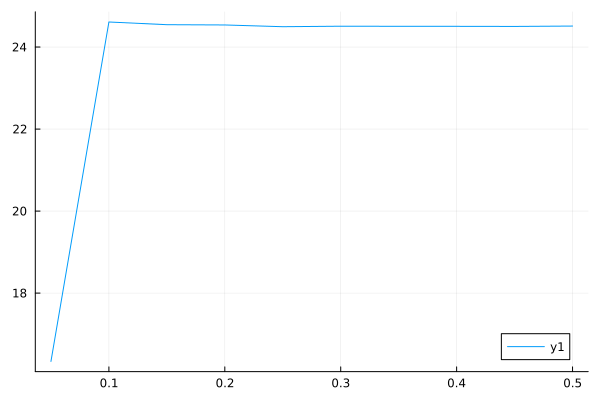

In [3]:
corr_len = [get_corr_len(correlations) for correlations in results]
temps = (1:length(corr_len)) * 0.05
p=plot(temps, corr_len)
display(p)

In [ ]:
# lattice = Lattice(100, 0.5, 0.05, "left")
# for _ in 1:1000000
#     sweep(lattice)
# end

# flip_equillibrium_flag(lattice)
# for _ in 1:1000
#     sweep(lattice)
# end
# println(lattice.avg_pop .* circshift(lattice.avg_pop, -1) / lattice.step_count^2)
# println(mean(extract_diagonal(lattice.second_moment_pop / lattice.step_count, 0) - (lattice.avg_pop .* circshift(lattice.avg_pop, -1) / lattice.step_count^2)))
# println(get_correlation_array(lattice))
# print_array_with_boxes(lattice.array)
# print_array_with_boxes(Int.(round.(get_avg_population(lattice))))
# plot(0:floor(lattice.size/2), get_correlation_array(lattice), label="T=0.05")